In [3]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from sklearn.externals import joblib

import seaborn as sns 
import random
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

In [4]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [5]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/ana-2-4-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


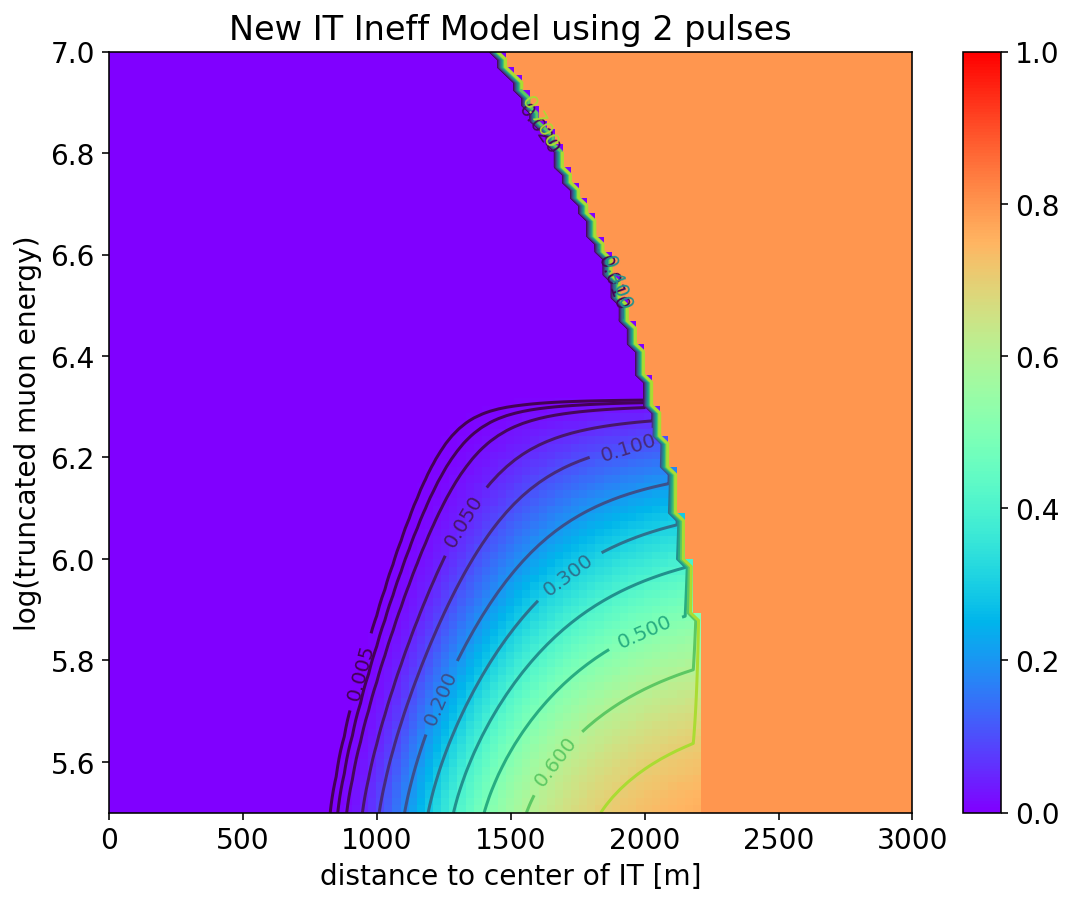

In [6]:
# OLD and NEW ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model.txt')
def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]
    
#     val = a * 1 / (1+np.exp(-(dist/2000-b)/c))
    val = a * np.exp(-b/(dist/2000)**(4.5))

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
    val[dist > 2210] = 0.8
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(9,7))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

In [7]:
with tables.open_file(data_dir+'data_h5/data_burn.h5','r') as f:
    nfile_data = [2831731.134,3081951.304,3158084.037,3155703.188,3082765.564]

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
#     CUT_ineff = ineff_ < ineffcut
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon
    
    ineff_data_burn_ = ineff_[CUT]
#     chi2_data_burn_ = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_data_burn_ = f.root.Collection.cols.chi2_red[:][CUT]
#     chi2_new_data_burn_ = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_data_burn_ = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_data_burn_ = f.root.Collection.cols.PeakOverMedian[:][CUT]
#     PeakOverMean_data_burn_ = f.root.Collection.cols.PeakOverMean[:][CUT]
    stoch_data_burn_ = (chi2_red_data_burn_ + (np.log10(PeakOverMedian_data_burn_)/2))/np.sqrt(2)
#     stoch_new_data_burn_ = np.log10(chi2_red_new_data_burn)/8 + np.log10(PeakOverMedian_data_burn)
    
    zenith_data_burn_ = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn_ = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_data_burn_ = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_data_burn_ = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_data_burn_ = f.root.QTot.cols.value[:][CUT]
    Qtot_data_burn_ = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_data_burn_ = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_data_burn_ = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_data_burn_ = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]

    closest_d_data_burn_ = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_data_burn_ = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_data_burn_ = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_data_burn_ = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]

#     IT_Npulse_data_burn_ = f.root.IT_veto_double.cols.num_Total_hits[:][CUT]
#     Npulse_in_window_data_burn_ = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:][CUT]
#     Npulse_off_window_data_burn_ = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:][CUT]

#     passed_2_data_burn_ = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
#     vetoed_2_data_burn_ = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    
    # IT TW cleaning
    passed_2_data_burn_ = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
    vetoed_2_data_burn_ = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    
    
    runid_data_burn_ = f.root.I3EventHeader.cols.Run[:][CUT]
    eventid_data_burn_ = f.root.I3EventHeader.cols.Event[:][CUT]

    weight_data_burn_ = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn_))


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [27]:
# from global optimization
cut_ineff = 0.09465517
cut_stoch = 2.68965517

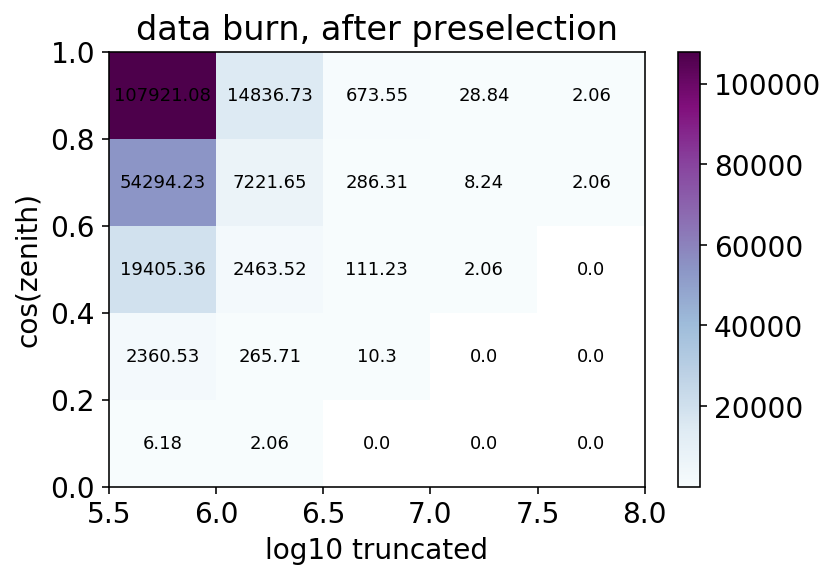

In [30]:
my_cmap = matplotlib.cm.get_cmap('BuPu')
my_cmap.set_under('w')

fig,ax = plt.subplots(figsize=(6,4))
h,xbins,ybins,img = plt.hist2d(np.log10(truncated_muon_e_data_burn_),np.cos(zenith_data_burn_),weights=weight_data_burn_,bins=[5,5],range=[[5.5,8],[0,1]],cmap=my_cmap,vmin=0.01)

xspace = 0.5
yspace = 0.2

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax.text(xbins[j]+xspace/2,ybins[i]+yspace/2, np.round(h.T[i,j],2), 
                color="black", ha="center", va="center",fontsize=9)
        
plt.colorbar()
plt.title('data burn, after preselection')
plt.xlabel('log10 truncated')
plt.ylabel('cos(zenith)')
plt.show()

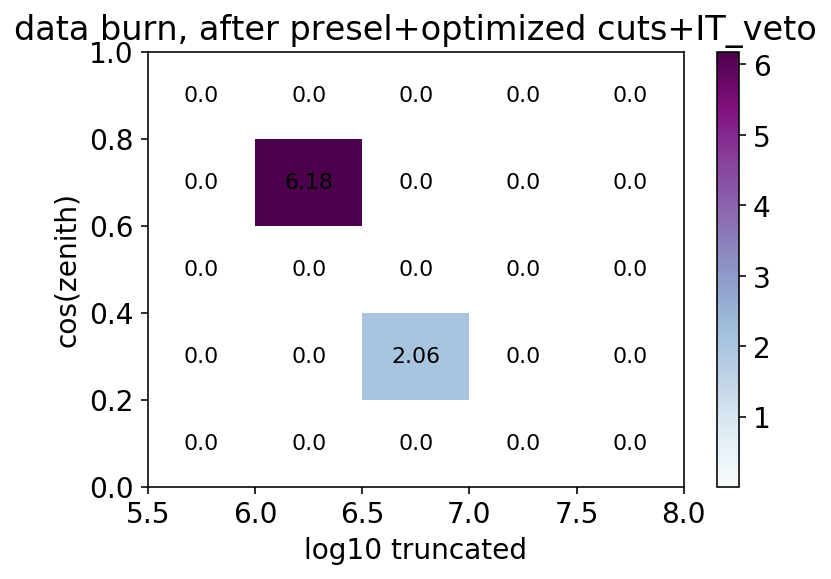

In [36]:
cut = (np.log10(chi2_red_new_data_burn_)>cut_stoch) & (ineff_data_burn_ < cut_ineff) & (passed_2_data_burn_)
fig,ax = plt.subplots(figsize=(6,4))
h,xbins,ybins,img = plt.hist2d(np.log10(truncated_muon_e_data_burn_)[cut],np.cos(zenith_data_burn_)[cut],weights=weight_data_burn_[cut],bins=[5,5],range=[[5.5,8],[0,1]],cmap=my_cmap,vmin=0.01)

xspace = 0.5
yspace = 0.2

for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        ax.text(xbins[j]+xspace/2,ybins[i]+yspace/2, np.round(h.T[i,j],2), 
                color="black", ha="center", va="center",fontsize=11)
        
plt.colorbar()
plt.title('data burn, after presel+optimized cuts+IT_veto')
plt.xlabel('log10 truncated')
plt.ylabel('cos(zenith)')
plt.show()